# Load the Data

In [ ]:
from google.colab import files
import pandas as pd

uploaded = files.upload()
file_name = list(uploaded.keys())[0]  # change the file name if necessary

# Load the data into a DataFrame
df = pd.read_csv(file_name, delimiter=',')  # Ensure the delimiter matches your file's format


Saving train_all_tasks.csv to train_all_tasks (3).csv


#Data Cleaning

In [ ]:
# Display basic info about the dataframe to understand any missing values or incorrect datatypes
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   rewire_id       14000 non-null  object
 1   text            14000 non-null  object
 2   label_sexist    14000 non-null  object
 3   label_category  14000 non-null  object
 4   label_vector    14000 non-null  object
dtypes: object(5)
memory usage: 547.0+ KB
None


In [ ]:
# Display the first few rows of the dataframe
print(df.head())

                  rewire_id  \
0   sexism2022_english-7358   
1   sexism2022_english-2367   
2   sexism2022_english-3073   
3  sexism2022_english-14895   
4   sexism2022_english-4118   

                                                text label_sexist  \
0              Damn, this writing was pretty chaotic   not sexist   
1  Yeah, and apparently a bunch of misogynistic v...   not sexist   
2       How the FUCK is this woman still an MP!!!???   not sexist   
3  Understand. Know you're right. At same time I ...   not sexist   
4     Surprized they didn't stop and rape some women   not sexist   

  label_category label_vector  
0           none         none  
1           none         none  
2           none         none  
3           none         none  
4           none         none  


In [ ]:
# Check for and sum up any missing values by column
print(df.isnull().sum())

rewire_id         0
text              0
label_sexist      0
label_category    0
label_vector      0
dtype: int64


In [ ]:
# Drop rows with any missing 'text' or 'label_sexist' data
if df.isnull().sum().any():
    df.dropna(subset=['text', 'label_sexist'], inplace=True)


# # Optional: Reset index after dropping rows
# df.reset_index(drop=True, inplace=True)

#Step 3: Text Preprocessing

In [ ]:
df.columns

Index(['rewire_id', 'text', 'label_sexist', 'label_category', 'label_vector'], dtype='object')

In [ ]:
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Function to preprocess text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Check if 'text' column exists in DataFrame
if 'text' in df.columns:
    # Apply preprocessing to each text entry
    df['text'] = df['text'].apply(preprocess_text)
    # Check the processed text
    print(df.head())
else:
    print("'text' column does not exist in the DataFrame.")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                  rewire_id  \
0   sexism2022_english-7358   
1   sexism2022_english-2367   
2   sexism2022_english-3073   
3  sexism2022_english-14895   
4   sexism2022_english-4118   

                                                text label_sexist  \
0                        damn writing pretty chaotic   not sexist   
1  yeah apparently bunch misogynistic virgins one...   not sexist   
2                                fuck woman still mp   not sexist   
3  understand know youre right time know isnt eno...   not sexist   
4                    surprized didnt stop rape women   not sexist   

  label_category label_vector  
0           none         none  
1           none         none  
2           none         none  
3           none         none  
4           none         none  


##Exploratory Data Analysis (EDA)
#Class Distribution

label_sexist
not sexist    10602
sexist         3398
Name: count, dtype: int64


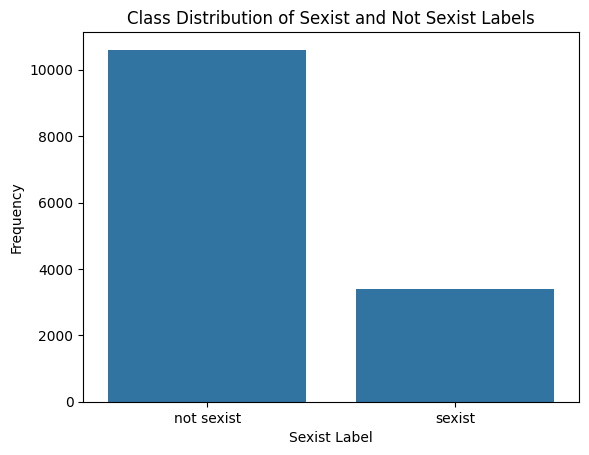

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class distribution
class_distribution = df['label_sexist'].value_counts()
print(class_distribution)

# Plot the distribution
sns.countplot(x=df['label_sexist'])
plt.title('Class Distribution of Sexist and Not Sexist Labels')
plt.xlabel('Sexist Label')
plt.ylabel('Frequency')
plt.show()


# Text Analysis
* Common Words by Category

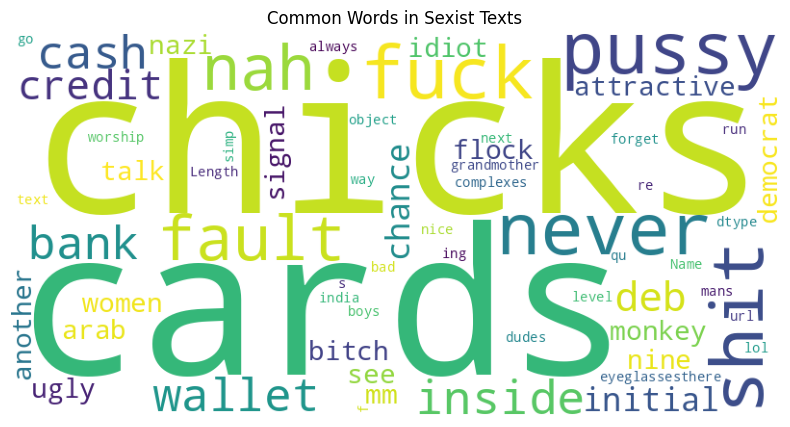

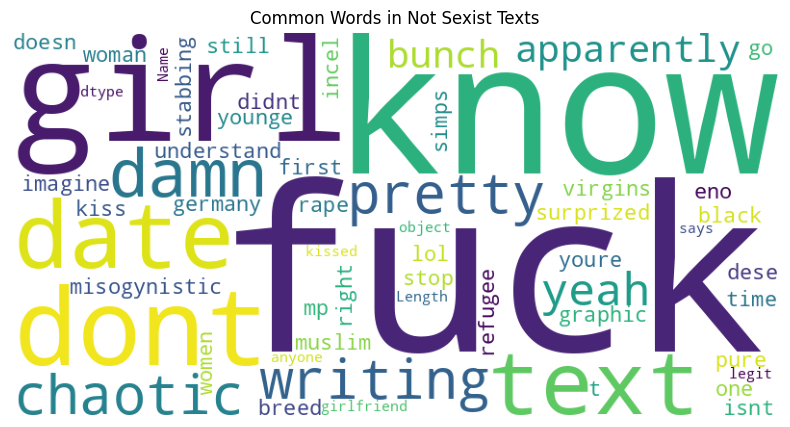

In [ ]:
from wordcloud import WordCloud

# Function to generate a word cloud
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(str(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate word clouds for each category
sexist_text = df[df['label_sexist'] == 'sexist']['text']
not_sexist_text = df[df['label_sexist'] == 'not sexist']['text']

generate_word_cloud(sexist_text, 'Common Words in Sexist Texts')
generate_word_cloud(not_sexist_text, 'Common Words in Not Sexist Texts')


#Average Length of Texts



Average length of sexist texts: 86.44
Average length of not sexist texts: 80.83


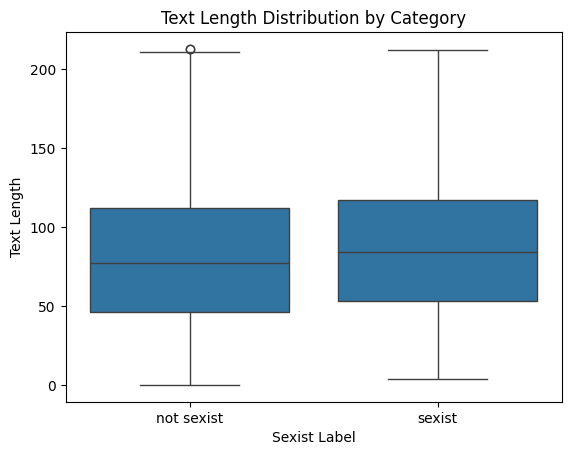

In [ ]:
# Calculate average length of the texts
df['text_length'] = df['text'].apply(len)
average_length_sexist = df[df['label_sexist'] == 'sexist']['text_length'].mean()
average_length_not_sexist = df[df['label_sexist'] == 'not sexist']['text_length'].mean()

print(f"Average length of sexist texts: {average_length_sexist:.2f}")
print(f"Average length of not sexist texts: {average_length_not_sexist:.2f}")

# Boxplot for text length distribution by category
sns.boxplot(x='label_sexist', y='text_length', data=df)
plt.title('Text Length Distribution by Category')
plt.xlabel('Sexist Label')
plt.ylabel('Text Length')
plt.show()

##Model Selection - Random Forest
Text Vectorization,
Split the Data,
Model Building

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Splitting the dataset into features and labels
X = df['text']  # Features
y = df['label_sexist']  # Target labels

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the text in the training and testing sets
X_train = X_train.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)

# Vectorizing the text data
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Training the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_tfidf, y_train)

# Predicting on the testing set
y_pred = rf_classifier.predict(X_test_tfidf)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Random Forest Classifier:", accuracy)


Accuracy of Random Forest Classifier: 0.8228571428571428


#Model Evaluation

#Model Performance Evaluation
Performance Metrics,
Confusion Matrix

Classification Report:
              precision    recall  f1-score   support

  not sexist       0.82      0.98      0.89      2096
      sexist       0.88      0.34      0.49       704

    accuracy                           0.82      2800
   macro avg       0.85      0.66      0.69      2800
weighted avg       0.83      0.82      0.79      2800


Confusion Matrix:
[[2064   32]
 [ 464  240]]


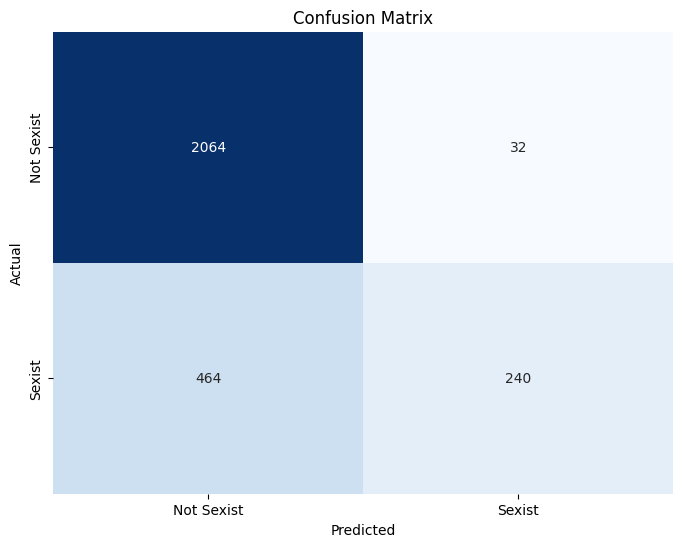

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=[0.5, 1.5], labels=['Not Sexist', 'Sexist'])
plt.yticks(ticks=[0.5, 1.5], labels=['Not Sexist', 'Sexist'])
plt.show()


#Data Preparation:

Filter the dataset to include only posts labeled as sexist.
Encode the target labels ("label_category") into numerical values corresponding to each category.


In [ ]:
# Step 1: Filter the dataset to include only posts labeled as sexist
sexist_posts = df[df['label_sexist'] == 'sexist']

# Step 2: Encode the target labels ("label_category") into numerical values corresponding to each category
# Mapping numerical values to each category
category_mapping = {
    "1. threats, plans to harm and incitement": 1,
    "2. derogation": 2,
    "3. animosity": 3,
    "4. prejudiced discussions": 4
}

# Encode the labels
sexist_posts['encoded_label_category'] = sexist_posts['label_category'].map(category_mapping)

# Check the frequency of the encoded labels
category_frequency = sexist_posts['encoded_label_category'].value_counts()
print("Frequency of Encoded Labels:")
print(category_frequency)


Frequency of Encoded Labels:
encoded_label_category
2    1590
3    1165
4     333
1     310
Name: count, dtype: int64


<ipython-input-13-f704d1840669>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sexist_posts['encoded_label_category'] = sexist_posts['label_category'].map(category_mapping)


#Feature Engineering

In [ ]:
# Step 1: Preprocess the text data
sexist_posts['processed_text'] = sexist_posts['text'].apply(preprocess_text)

# Step 2: Vectorize the text data using TF-IDF vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the processed text data
tfidf_matrix = tfidf_vectorizer.fit_transform(sexist_posts['processed_text'])

# Convert the TF-IDF matrix to a DataFrame for better visualization (optional)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Check the shape of the TF-IDF matrix
print("Shape of TF-IDF matrix:", tfidf_matrix.shape)


<ipython-input-14-fd94529f21d8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sexist_posts['processed_text'] = sexist_posts['text'].apply(preprocess_text)


Shape of TF-IDF matrix: (3398, 9414)


#Proceed with model selection, training, and evaluation using Support Vector Machine (SVM) for multi-class classification

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Split the dataset into features (TF-IDF matrix) and target labels
X = tfidf_matrix
y = sexist_posts['encoded_label_category']

# Step 2: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train the SVM model on the training data
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
svm_classifier.fit(X_train, y_train)

# Step 4: Evaluate the trained model's performance
# Predict on the testing set
y_pred = svm_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)


Accuracy: 0.5352941176470588

Classification Report:
              precision    recall  f1-score   support

           1       0.81      0.30      0.44        57
           2       0.54      0.77      0.63       328
           3       0.48      0.38      0.43       227
           4       0.73      0.12      0.20        68

    accuracy                           0.54       680
   macro avg       0.64      0.39      0.42       680
weighted avg       0.56      0.54      0.50       680


Confusion Matrix:
[[ 17  30   9   1]
 [  2 252  73   1]
 [  1 138  87   1]
 [  1  47  12   8]]


Category Mapping:
dict_keys(['1. threats, plans to harm and incitement', '2. derogation', '3. animosity', '4. prejudiced discussions'])


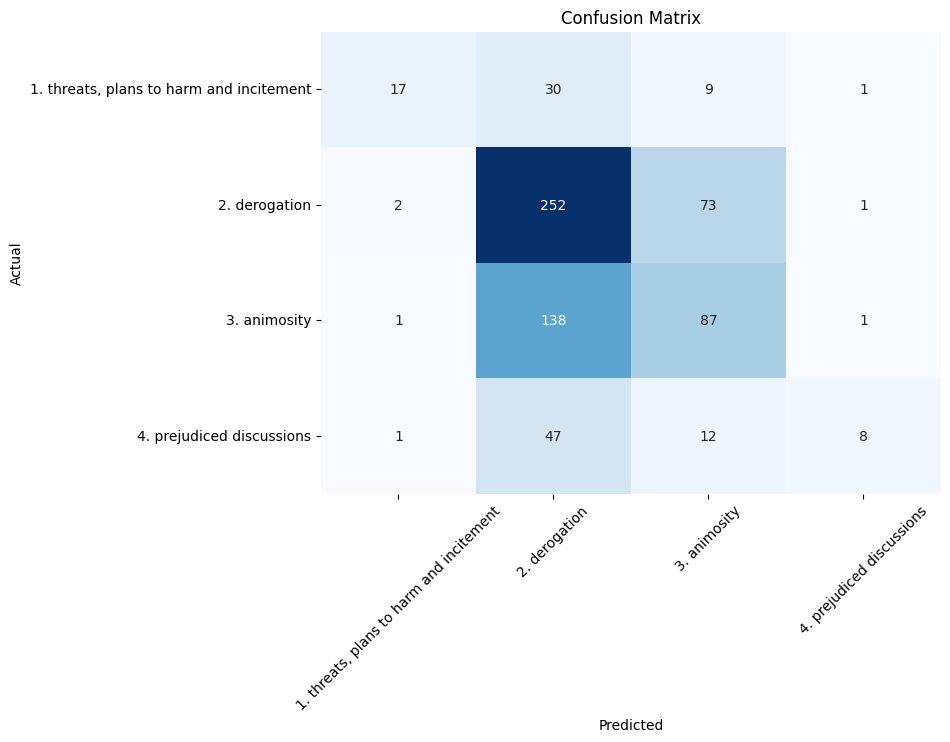

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("Category Mapping:")
print(category_mapping.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=np.arange(0.5, len(category_mapping.keys()) + 0.5), labels=list(category_mapping.keys()), rotation=45)
plt.yticks(ticks=np.arange(0.5, len(category_mapping.keys()) + 0.5), labels=list(category_mapping.keys()), rotation=0)
plt.show()



#TASK C - Fine-grained Vector of Sexism

In [ ]:
# Get unique values from the "label_vector" column
unique_categories = df['label_vector'].unique()

# Count the number of unique categories
num_categories = len(unique_categories)

print("Number of different categories in the 'label_vector' column:", num_categories)

# Print each unique category
print("Unique categories in the 'label_vector' column:")
for category in unique_categories:
    print(category)


Number of different categories in the 'label_vector' column: 12
Unique categories in the 'label_vector' column:
none
2.3 dehumanising attacks & overt sexual objectification
2.1 descriptive attacks
1.2 incitement and encouragement of harm
3.1 casual use of gendered slurs, profanities, and insults
4.2 supporting systemic discrimination against women as a group
2.2 aggressive and emotive attacks
3.2 immutable gender differences and gender stereotypes
3.4 condescending explanations or unwelcome advice
3.3 backhanded gendered compliments
4.1 supporting mistreatment of individual women
1.1 threats of harm


# Data preparation and Feature engineering

In [ ]:
# Step 1: Ensure you have a dataset containing posts labeled as sexist and the corresponding fine-grained vector of sexism in the "label_vector" column.
# Assuming df is your DataFrame containing the dataset

# Step 2: Verify the structure of the dataset and ensure it includes the necessary columns.
print("Dataset Structure:")
print(df.info())

# Step 3: Feature Engineering
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Download stopwords list if not already downloaded
nltk.download('stopwords')

# Preprocess the text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply text preprocessing
df['clean_text'] = df['text'].apply(preprocess_text)

# Optionally, perform additional text normalization techniques such as stemming or lemmatization.

# Vectorize the preprocessed text data using TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_text'])

# Display the shape of the TF-IDF matrix
print("Shape of TF-IDF matrix:", tfidf_matrix.shape)


Dataset Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   rewire_id       14000 non-null  object
 1   text            14000 non-null  object
 2   label_sexist    14000 non-null  object
 3   label_category  14000 non-null  object
 4   label_vector    14000 non-null  object
 5   text_length     14000 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 656.4+ KB
None


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Shape of TF-IDF matrix: (14000, 22777)


#LSTM

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the dataset
# Assuming df is your DataFrame containing the dataset
texts = df['text']
labels = df['label_vector']

# Split the dataset into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad sequences to ensure uniform length
max_len = max(len(seq) for seq in train_sequences)
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post')

# Convert labels to numerical values
label_dict = {label: idx for idx, label in enumerate(labels.unique())}
train_labels = [label_dict[label] for label in train_labels]
test_labels = [label_dict[label] for label in test_labels]

# Convert labels to numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=max_len))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(label_dict), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_sequences, train_labels, epochs=20, batch_size=64, validation_data=(test_sequences, test_labels))

# Get raw predictions
predictions = model.predict(test_sequences)
# Convert probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Evaluate the model
accuracy = accuracy_score(test_labels, predicted_labels)
print("Accuracy:", accuracy)

classification_rep = classification_report(test_labels, predicted_labels)
print("Classification Report:")
print(classification_rep)

conf_matrix = confusion_matrix(test_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)


Epoch 1/20
175/175 [==============================] - 41s 201ms/step - loss: 1.1154 - accuracy: 0.7557 - val_loss: 1.0842 - val_accuracy: 0.7482
Epoch 2/20
175/175 [==============================] - 29s 166ms/step - loss: 0.8822 - accuracy: 0.7674 - val_loss: 1.0274 - val_accuracy: 0.7725
Epoch 3/20
175/175 [==============================] - 36s 206ms/step - loss: 0.6818 - accuracy: 0.7975 - val_loss: 1.0684 - val_accuracy: 0.7632
Epoch 4/20
175/175 [==============================] - 30s 169ms/step - loss: 0.5875 - accuracy: 0.8179 - val_loss: 1.1571 - val_accuracy: 0.7521
Epoch 5/20
175/175 [==============================] - 30s 171ms/step - loss: 0.5255 - accuracy: 0.8311 - val_loss: 1.1330 - val_accuracy: 0.7507
Epoch 6/20
175/175 [==============================] - 30s 169ms/step - loss: 0.4849 - accuracy: 0.8403 - val_loss: 1.3769 - val_accuracy: 0.7375
Epoch 7/20
175/175 [==============================] - 31s 175ms/step - loss: 0.4470 - accuracy: 0.8477 - val_loss: 1.2579 - val_ac

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Confusion matrix

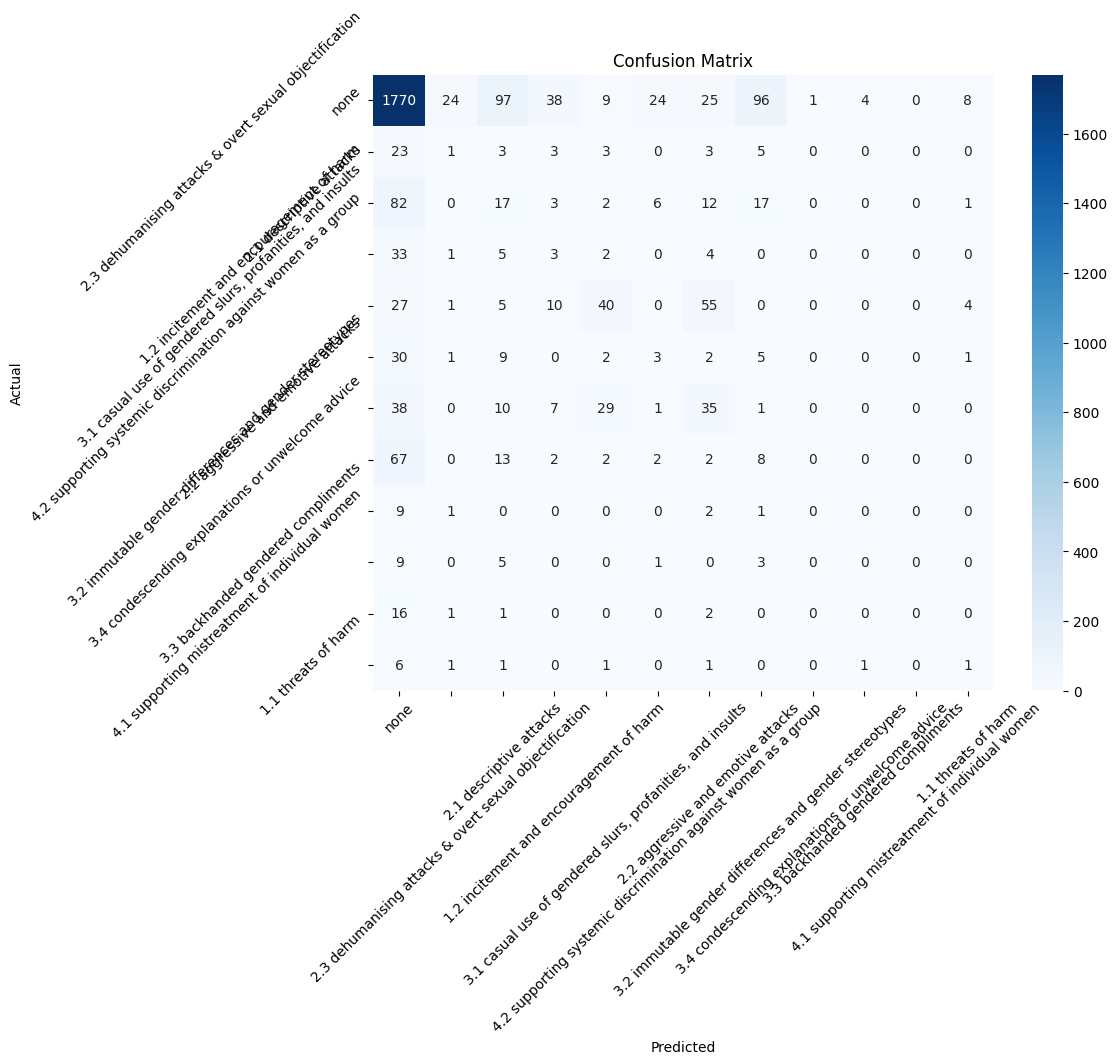

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()


#Classification Report


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


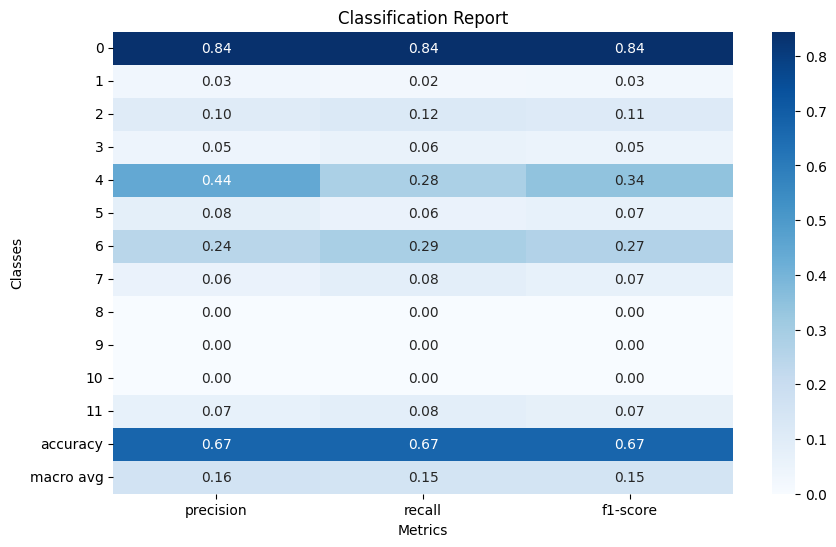

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Convert classification report to a DataFrame
report_dict = classification_report(test_labels, predicted_labels, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Plot classification report
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt='.2f')
plt.title('Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()
